## Predict 2 meter temperature with sea surface temperature using linear regression
This notebook serves as an example of a basic workflow of data driven forecasting using machine learning with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with linear regression (Ridge). <br>

<img src="../assets/concept_test_case.png" alt="usecase" width="500"/>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (test data, accessible via `era5cli`)
- Map the calendar to the data (`lilio`)
- Train-test split (70%/30%)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Dimensionality reduction and cross-validation (`lilio` & `scikit-learn`)
- Training and testing the model
- Saving the trained model with `onnx`

The workflow is illustrated below:

<img src="../assets/regression.PNG" alt="Ridge" width="900"/>

### 0 - Libraries

In [13]:
import lilio
import urllib
import xarray as xr
from s2spy import preprocess
from s2spy import RGDR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from skl2onnx import to_onnx
import numpy as np
import onnxruntime as ort

### 1 - Define a calendar with `lilio`

Specify a time range for precursor and target intervals. 

In this example, we are creating a calendar with an anchor date of 8th January, a target of 30 days and 8 precursor intervals of 1 month each. 

In [14]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [15]:
# Check calendar
calendar

Calendar(
    anchor='08-01',
    allow_overlap=True,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='0d'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M')
    ]
)

### 2 - Load datasets

Load Sea Surface Temperature (SST) and (clustered) 2m air temperature data (T2M). Here we use data from 1959-2021 (63 years total). 

In [16]:
def load_data(url, field, var):
    # Download and load dataset
    url_field = url + field
    urllib.request.urlretrieve(url_field, field)
    dataset = xr.open_dataset(field)
    dataset[var] = dataset[var] - 273.15
    return dataset 

In [17]:
# URL of the dataset from zenodo
url = "https://zenodo.org/record/8186914/files/"

sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"

In [18]:
precursor_field = load_data(url, sst_field, "sst")
target_field = load_data(url, t2m_field, "t2m")

#### 3 - Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

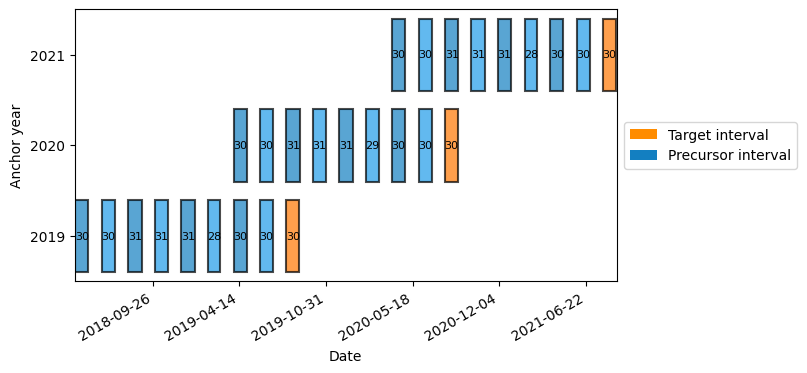

In [19]:
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [20]:
# show first 5 anchor years in the calendar
calendar.show()[:5]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2021,"[2020-04-01, 2020-05-01)","[2020-06-01, 2020-07-01)","[2020-08-01, 2020-09-01)","[2020-10-01, 2020-11-01)","[2020-12-01, 2021-01-01)","[2021-02-01, 2021-03-01)","[2021-04-01, 2021-05-01)","[2021-06-01, 2021-07-01)","[2021-08-01, 2021-08-31)"
2020,"[2019-04-01, 2019-05-01)","[2019-06-01, 2019-07-01)","[2019-08-01, 2019-09-01)","[2019-10-01, 2019-11-01)","[2019-12-01, 2020-01-01)","[2020-02-01, 2020-03-01)","[2020-04-01, 2020-05-01)","[2020-06-01, 2020-07-01)","[2020-08-01, 2020-08-31)"
2019,"[2018-04-01, 2018-05-01)","[2018-06-01, 2018-07-01)","[2018-08-01, 2018-09-01)","[2018-10-01, 2018-11-01)","[2018-12-01, 2019-01-01)","[2019-02-01, 2019-03-01)","[2019-04-01, 2019-05-01)","[2019-06-01, 2019-07-01)","[2019-08-01, 2019-08-31)"
2018,"[2017-04-01, 2017-05-01)","[2017-06-01, 2017-07-01)","[2017-08-01, 2017-09-01)","[2017-10-01, 2017-11-01)","[2017-12-01, 2018-01-01)","[2018-02-01, 2018-03-01)","[2018-04-01, 2018-05-01)","[2018-06-01, 2018-07-01)","[2018-08-01, 2018-08-31)"
2017,"[2016-04-01, 2016-05-01)","[2016-06-01, 2016-07-01)","[2016-08-01, 2016-09-01)","[2016-10-01, 2016-11-01)","[2016-12-01, 2017-01-01)","[2017-02-01, 2017-03-01)","[2017-04-01, 2017-05-01)","[2017-06-01, 2017-07-01)","[2017-08-01, 2017-08-31)"


### 4 - Train-test split based on the anchor years (70%/30% split)
This can be refered to as the "outer cross-validation layer".

In [21]:
def train_test_split(calendar, field):
    years = sorted(calendar.get_intervals().index)
    start_year = years[0]
    end_year = years[-1]

    # get 70% of instance as training
    train_samples = round(len(years) * 0.7)
    train = field.sel(time=slice(str(start_year), str(start_year + train_samples - 1)))

    # get 30% of instance as testing 
    test = field.sel(time=slice(str(start_year + train_samples), str(end_year -1)))

    return train, test

In [22]:
train_slice, test_slice = train_test_split(calendar, precursor_field)
target_train_slice, target_test_slice = train_test_split(calendar, target_field)

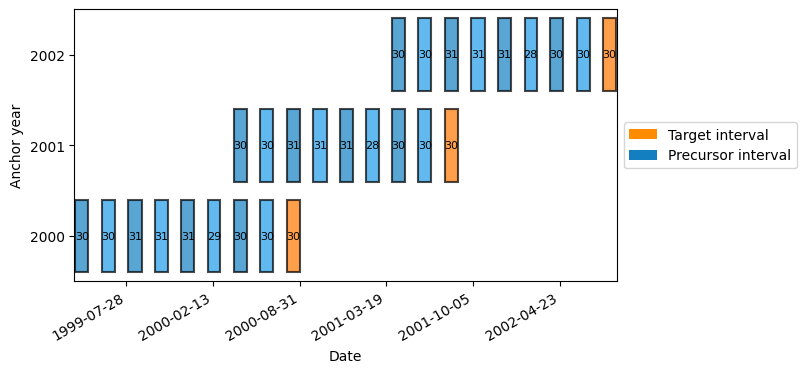

In [23]:
calendar.map_to_data(train_slice)
calendar.visualize(show_length=True)

### 5 - Fit preprocessor with training samples and preprocess data
In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

In [38]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(train_slice)

/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/s2spy/preprocess.py:158: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(


In [39]:
train_prep = preprocessor.transform(train_slice)

### 6 - Resample data to the calendar

In [40]:
precursor_field_resample = lilio.resample(calendar, train_prep)
target_field_resample = lilio.resample(calendar, target_train_slice)

precursor_field_resample

<xarray.Dataset> Size: 203kB
Dimensions:      (anchor_year: 42, i_interval: 9, latitude: 5, longitude: 13)
Coordinates:
  * anchor_year  (anchor_year) int64 336B 1961 1962 1963 1964 ... 2000 2001 2002
  * i_interval   (i_interval) int64 72B -8 -7 -6 -5 -4 -3 -2 -1 1
  * longitude    (longitude) float64 104B 177.5 182.5 187.5 ... 232.5 237.5
  * latitude     (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
    left_bound   (anchor_year, i_interval) datetime64[ns] 3kB 1960-04-01 ... ...
    right_bound  (anchor_year, i_interval) datetime64[ns] 3kB 1960-05-01 ... ...
    is_target    (i_interval) bool 9B False False False ... False False True
Data variables:
    sst          (anchor_year, i_interval, latitude, longitude) float64 197kB ...
Attributes:
    lilio_version:               0.5.0
    lilio_calendar_anchor_date:  08-01
    lilio_calendar_code:         Calendar(\n    anchor='08-01',\n    allow_ov...
    history:                     2024-11-07 13:49:20 UTC - Resampled with a L...

In [41]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['t2m'].sel(cluster=3)

precursor_field_sel.head()

<xarray.DataArray 'sst' (anchor_year: 5, i_interval: 5, latitude: 5,
                         longitude: 5)> Size: 5kB
array([[[[-3.49072742e-01, -4.87465539e-01, -3.64992088e-01,
          -1.78519565e-01, -5.28177770e-01],
         [-1.19766356e+00, -8.46902308e-01, -8.32997334e-01,
          -8.64524022e-01, -1.36112857e+00],
         [-1.86829582e-01, -6.90303759e-01, -5.91457867e-01,
          -6.36831442e-01, -9.85782294e-01],
         [ 4.46952481e-01, -2.81804812e-01, -2.63434861e-01,
          -5.13153974e-01, -6.53762887e-01],
         [ 9.09750097e-01,  4.04606525e-01, -1.93562943e-01,
          -5.50191705e-01, -3.35220126e-01]],

        [[-5.29288359e-01, -6.78476389e-01, -8.09645967e-01,
          -7.91371853e-01, -1.04794980e+00],
         [-1.52815885e+00, -1.43967273e+00, -1.41322861e+00,
          -1.45478578e+00, -1.76174148e+00],
         [-9.40783258e-01, -7.03445023e-01, -8.65244276e-01,
          -7.29616489e-01, -6.25675775e-01],
         [-8.65128015e-01, -4.75390394e-01,  8.66609415e-02,
           1.41481538e-01,  1.00313904e-01],
         [ 6.82425951e-01,  7.38634986e-01,  5.62030255e-01,
...
          -4.52701852e-01, -4.05765298e-01],
         [-9.50263760e-01, -3.20446692e-01, -4.16379905e-03,
           7.20540280e-01,  1.71971892e-01],
         [ 7.85978299e-01,  1.49393215e+00,  1.43608666e+00,
           1.20731327e+00,  8.42571713e-01],
         [ 1.20537564e+00,  1.58371066e+00,  1.08776824e+00,
           7.97292099e-01,  1.71241036e-01],
         [ 8.68723959e-01,  4.83367807e-01,  1.67145453e-01,
          -2.83316370e-01, -5.12902714e-01]],

        [[ 3.32331574e-01,  7.10767476e-01,  7.14296577e-01,
           4.99007658e-01,  2.92404646e-01],
         [ 5.06040392e-01,  8.51496216e-01,  1.13038051e+00,
           1.05893688e+00,  1.03207915e+00],
         [-1.97931587e-01, -5.00706413e-02,  7.67259189e-02,
           2.63330268e-01,  7.49140145e-01],
         [-7.96210393e-01, -1.72099361e-03,  6.48604387e-03,
          -2.64381699e-02,  4.65934940e-01],
         [-4.64010306e-01, -3.93388366e-01, -2.04925717e-01,
          -1.66404509e-01,  9.80129219e-02]]]])
Coordinates:
  * anchor_year  (anchor_year) int64 40B 1961 1962 1963 1964 1965
  * i_interval   (i_interval) int64 40B -8 -7 -6 -5 -4
  * longitude    (longitude) float64 40B 177.5 182.5 187.5 192.5 197.5
  * latitude     (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
    left_bound   (anchor_year, i_interval) datetime64[ns] 200B 1960-04-01 ......
    right_bound  (anchor_year, i_interval) datetime64[ns] 200B 1960-05-01 ......
    is_target    (i_interval) bool 5B False False False False False

### 7 - Train-test split -> dimensionality reduction & model fitting
Train-test split based on the previous split, which can be refered to as "inner cross-validation layer" (outer cv loop -> inner cv loop). <br>
For each split, we will perform dimensionality reduction and fit the model.

For simplicity, in this example we only perform dimensionality reduction with RGDR with only one target interval and one lag. But in practice you can have multiple target intervals and multiple lags. <br>
For more information, here is a nice example about multiple target intervals in the [tutorial notebook](https://github.com/AI4S2S/s2spy/blob/main/docs/notebooks/tutorial_RGDR.ipynb) of RGDR.

In [42]:
# cross-validation with Kfold
k_fold_splits = 5
kfold = KFold(n_splits=k_fold_splits)
cv = lilio.traintest.TrainTestSplit(kfold)

# create lists for saving models and predictions
models = []
predictions = []
rmse_train = []
rmse_test = []
train_test_splits = []

# prepare operator for dimensionality reduction
target_intervals = 1
lag = 1
rgdr = RGDR(
    target_intervals=target_intervals,
    lag=lag,
    eps_km=600,
    alpha=0.05,
    min_area_km2=0
)

# cross validation based dimensionality reduction and model training
for x_train, x_test, y_train, y_test in cv.split(precursor_field_sel, y=target_series_sel):
    # log train/test splits with anchor years
    train_test_splits.append({
        "train": x_train.anchor_year.values,
        "test": x_test.anchor_year.values,
    })
    # fit dimensionality reduction operator RGDR
    rgdr.fit(x_train, y_train)
    # transform to train and test data
    clusters_train = rgdr.transform(x_train)
    clusters_test = rgdr.transform(x_test)
    # train model
    ridge = Ridge(alpha=1.0)
    model = ridge.fit(clusters_train.isel(i_interval=0), y_train.sel(i_interval=1))
    # save model
    models.append(model)
    # predict and save results
    prediction = model.predict(clusters_test.isel(i_interval=0))
    predictions.append(prediction)
    # calculate and save rmse
    rmse_train.append(mean_squared_error(y_train.sel(i_interval=1),
                                         model.predict(clusters_train.isel(i_interval=0))))
    rmse_test.append(mean_squared_error(y_test.sel(i_interval=1),
                                        prediction))

#### Plot the RMSE for both training and testing for each experiment (split)

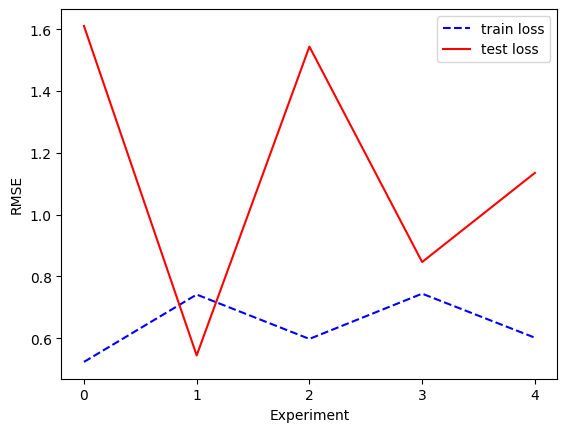

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(k_fold_splits), rmse_train, "b--", label = "train loss")
plt.plot(range(k_fold_splits), rmse_test, "r", label = "test loss")
ax = fig.gca()
ax.set_xticks(range(k_fold_splits))
plt.xlabel("Experiment")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### 8 - Train the model on all training data

In [44]:
# Train model on all training data

rgdr.fit(precursor_field_sel, target_series_sel)

# transform to data
clusters = rgdr.transform(precursor_field_sel)

# train model
ridge = Ridge(alpha=1.0)
model = ridge.fit(clusters.isel(i_interval=0), target_series_sel.sel(i_interval=1))

model

Ridge()

In [45]:
print("Coefficients:", ridge.coef_)
print("Intercept:", ridge.intercept_)


Coefficients: [-0.4537564  -0.2521273  -0.22968529  0.36834681]
Intercept: 22.97288504237645


### 9 - Test the model with test data 

In [46]:
# Prepare test data
calendar.map_to_data(test_slice)
test_prep = preprocessor.transform(test_slice)
precursor_test_resample = lilio.resample(calendar, test_prep)
target_test_resample = lilio.resample(calendar, target_test_slice)
precursor_test_sel = precursor_test_resample['sst']
target_test_sel = target_test_resample['t2m'].sel(cluster=3)

clusters_test = rgdr.transform(precursor_test_sel)

clusters_test


<xarray.DataArray 'sst' (anchor_year: 17, i_interval: 1, cluster_labels: 4)> Size: 544B
array([[[ 0.84984631,  0.15386392,  0.02832874, -1.2008396 ]],

       [[-0.2175201 ,  0.46471084,  0.01142347,  0.25819813]],

       [[-0.48630654,  0.35550547,  1.06793638, -0.09396613]],

       [[ 0.00581012, -0.55896247,  0.94164391,  0.61165668]],

       [[ 0.62784   ,  0.35800312,  1.14551882, -0.2005548 ]],

       [[ 1.0515113 ,  1.48581972,  1.02539802, -0.40428868]],

       [[-1.16993814, -0.20151344, -0.08392872,  0.83085988]],

       [[-1.38409534,  0.61204365,  0.07024654,  1.58529556]],

       [[-0.83333175, -0.16906922, -0.16475285,  1.01749021]],

       [[ 1.02709558,  0.86014317,  0.43980083,  0.46346946]],

       [[ 1.3586731 ,  1.34613874,  0.50854823, -0.59299777]],

       [[ 2.22862868,  0.61715229,  0.04581268,  0.52226554]],

       [[ 1.10393265,  0.35315965,  0.30699859,  1.35791681]],

       [[-0.37171664,  0.07155404,  0.39319798,  1.03644611]],

       [[ 0.09147755,  0.25277665, -0.03602316,  0.70783227]],

       [[ 1.10537132,  1.10952415,  0.67234114, -0.05042737]],

       [[ 0.94322166,  1.24624315,  0.38120161,  2.14993948]]])
Coordinates:
  * anchor_year     (anchor_year) int64 136B 2004 2005 2006 ... 2018 2019 2020
  * i_interval      (i_interval) int64 8B -1
    left_bound      (anchor_year, i_interval) datetime64[ns] 136B 2004-06-01 ...
    right_bound     (anchor_year, i_interval) datetime64[ns] 136B 2004-07-01 ...
    is_target       (i_interval) bool 1B False
  * cluster_labels  (cluster_labels) int16 8B -3 -2 -1 1
    latitude        (cluster_labels) float64 32B 40.41 45.39 47.5 27.5
    longitude       (cluster_labels) float64 32B 223.5 200.0 177.5 177.5
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

In [47]:
rgdr.corr_map

<xarray.DataArray (latitude: 5, longitude: 13)> Size: 520B
array([[-0.32778963, -0.27458967, -0.38335978, -0.40749557, -0.48417067,
        -0.44968601, -0.36406961, -0.35221454, -0.27863727, -0.30408335,
        -0.14775304, -0.07626832,         nan],
       [-0.28509255, -0.2125832 , -0.28390843, -0.35518096, -0.38165656,
        -0.34820303, -0.3096531 , -0.26138862, -0.31956773, -0.41128364,
        -0.31537788, -0.13622473,         nan],
       [ 0.05023067,  0.15309425,  0.12397229,  0.03559158, -0.00391193,
        -0.04864426, -0.05550864, -0.1305932 , -0.30040371, -0.39367396,
        -0.31367194, -0.13788089,         nan],
       [ 0.22275468,  0.27102412,  0.22910231,  0.25935626,  0.21294646,
         0.13707815,  0.01873517, -0.11190201, -0.18306387, -0.21193226,
        -0.26846949, -0.20168824, -0.09044905],
       [ 0.33516394,  0.25184303,  0.24883246,  0.20020218,  0.11344537,
         0.0618208 , -0.0295901 , -0.12534284, -0.20238454, -0.26131089,
        -0.23075436, -0.16810213, -0.05302121]])
Coordinates:
  * longitude   (longitude) float64 104B 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * latitude    (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
    n_clusters  int64 8B 6
    cluster     int64 8B 3

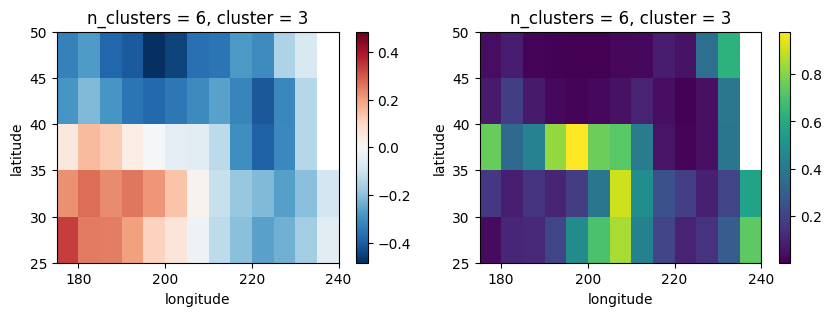

In [48]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=2)

# Visualize correlation map after RGDR().fit(precursor_field, target_timeseries)
rgdr.corr_map.plot(ax=ax1)

# Visualize p-values map
rgdr.pval_map.plot(ax=ax2)



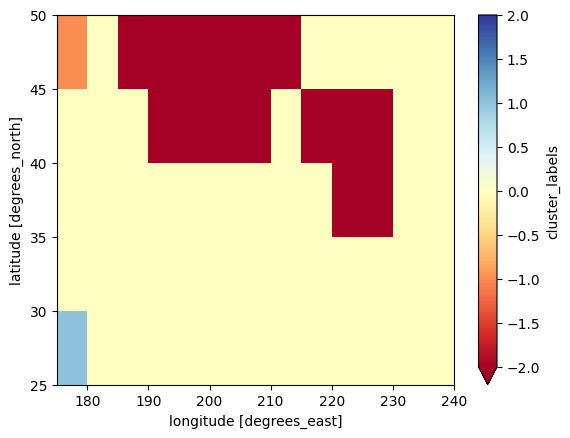

In [49]:
rgdr.cluster_map.plot(cmap='RdYlBu', vmin=-2, vmax=2)

In [50]:
# Predict on the training set
y_train_pred = ridge.predict(clusters.isel(i_interval=0))

# Predict on the test set
y_test_pred = ridge.predict(clusters_test.isel(i_interval=0))

# Evaluate performance
mse_train = mean_squared_error(target_series_sel.sel(i_interval=1), y_train_pred)
mse_test = mean_squared_error(target_test_sel.sel(i_interval=1), y_test_pred)

print("Training MSE:", mse_train)
print("Test MSE:", mse_test)


Training MSE: 0.6636450845681127
Test MSE: 1.1150480957674667


### 10 - Save model to ONNX

In [51]:
# Save model to ONNX 

onnx_model = to_onnx(model, clusters.isel(i_interval=0)[:1].values.astype(np.float32), target_opset=12)
# save model
with open("./model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [52]:
import onnxruntime as ort

# Load the ONNX model
model_path = 'model.onnx'
session = ort.InferenceSession(model_path)
pred_ort = session.run(None, {"X": clusters_test.isel(i_interval=0).values.astype(np.float32)})[0]

pred_ort


array([[22.099636],
       [23.046902],
       [22.824017],
       [23.1202  ],
       [22.260754],
       [21.736702],
       [23.87988 ],
       [24.014418],
       [23.806273],
       [22.35967 ],
       [21.681746],
       [21.987883],
       [22.8126  ],
       [23.414972],
       [23.136646],
       [22.018574],
       [22.935047]], dtype=float32)